#**Detecting FRAUD transactions of ETHEREUM**

###Checking the specs of the machine

In [1]:
!nvidia-smi

Sun Oct  6 09:04:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   46C    P8              11W /  72W |      1MiB / 23034MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

##**Step 1: Import and Standardization of dataset**

In [2]:
%pip install -q pandas matplotlib numpy seaborn scikit-learn==1.2.2 imbalanced-learn torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 76.4 MB/s eta 0:00:00


<p style="font-family: Fantasy, fantasy; line-height: 1.3;font-size: 30px; letter-spacing: 5px;  color: #4d4dff">Dataset information </p>

This dataset contains rows of known fraud and valid transactions made over Ethereum, a type of cryptocurrency.

Here is a description of the rows of the dataset:
- Index: the index number of a row
- Address: the address of the ethereum account
- FLAG: whether the transaction is fraud or not
- Avg min between sent tnx: Average time between sent transactions for account in minutes
- Avg min between received tnx: Average time between received transactions for account in minutes
- Time Diff between first and_last (Mins): Time difference between the first and last transaction
- Sent_tnx: Total number of sent normal transactions
- Received_tnx: Total number of received normal transactions
- NumberofCreated_Contracts: Total Number of created contract transactions
- UniqueReceivedFrom_Addresses: Total Unique addresses from which account received transaction
- UniqueSentTo_Addresses20: Total Unique addresses from which account sent transactions
- MinValueReceived: Minimum value in Ether ever received
- MaxValueReceived: Maximum value in Ether ever received
- AvgValueReceived5Average value in Ether ever received
- MinValSent: Minimum value of Ether ever sent
- MaxValSent: Maximum value of Ether ever sent
- AvgValSent: Average value of Ether ever sent
- MinValueSentToContract: Minimum value of Ether sent to a contract
- MaxValueSentToContract: Maximum value of Ether sent to a contract
- AvgValueSentToContract: Average value of Ether sent to contracts
- TotalTransactions(IncludingTnxtoCreate_Contract): Total number of transactions
- TotalEtherSent:Total Ether sent for account address
- TotalEtherReceived: Total Ether received for account address
- TotalEtherSent_Contracts: Total Ether sent to Contract addresses
- TotalEtherBalance: Total Ether Balance following enacted transactions
- TotalERC20Tnxs: Total number of ERC20 token transfer transactions
- ERC20TotalEther_Received: Total ERC20 token received transactions in Ether
- ERC20TotalEther_Sent: Total ERC20token sent transactions in Ether
- ERC20TotalEtherSentContract: Total ERC20 token transfer to other contracts in Ether
- ERC20UniqSent_Addr: Number of ERC20 token transactions sent to Unique account addresses
- ERC20UniqRec_Addr: Number of ERC20 token transactions received from Unique addresses
- ERC20UniqRecContractAddr: Number of ERC20token transactions received from Unique contract addresses
- ERC20AvgTimeBetweenSent_Tnx: Average time between ERC20 token sent transactions in minutes
- ERC20AvgTimeBetweenRec_Tnx: Average time between ERC20 token received transactions in minutes
- ERC20AvgTimeBetweenContract_Tnx: Average time ERC20 token between sent token transactions
- ERC20MinVal_Rec: Minimum value in Ether received from ERC20 token transactions for account
- ERC20MaxVal_Rec: Maximum value in Ether received from ERC20 token transactions for account
- ERC20AvgVal_Rec: Average value in Ether received from ERC20 token transactions for account
- ERC20MinVal_Sent: Minimum value in Ether sent from ERC20 token transactions for account
- ERC20MaxVal_Sent: Maximum value in Ether sent from ERC20 token transactions for account
- ERC20AvgVal_Sent: Average value in Ether sent from ERC20 token transactions for account
- ERC20UniqSentTokenName: Number of Unique ERC20 tokens transferred
- RC20UniqRecTokenName: Number of Unique ERC20 tokens received
- ERC20MostSentTokenType: Most sent token for account via ERC20 transaction
- ERC20MostRecTokenType: Most received token for account via ERC20 transactions

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


###Libraries

In [4]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer
from imblearn.over_sampling import SMOTE

###Data Reading

In [5]:
df = pd.read_csv('/content/drive/MyDrive/tesi/transaction_dataset.csv', index_col=0)
#df = pd.read_csv('transaction_dataset.csv', index_col=0)
print(df.shape)
df.head()

(9841, 50)


,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,40,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,5,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,10,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,NaN,XENON
3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,7,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,7,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS


In [6]:
df.describe()

,Index,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,1815.049893,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,...,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,1222.621830,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,...,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,821.000000,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,1641.000000,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,2601.000000,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,...,9.900000e+01,2.946467e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2.000000
max,4729.000000,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 50 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   Index                                                 9841 non-null   int64  
 1   Address                                               9841 non-null   object 
 2   FLAG                                                  9841 non-null   int64  
 3   Avg min between sent tnx                              9841 non-null   float64
 4   Avg min between received tnx                          9841 non-null   float64
 5   Time Diff between first and last (Mins)               9841 non-null   float64
 6   Sent tnx                                              9841 non-null   int64  
 7   Received Tnx                                          9841 non-null   int64  
 8   Number of Created Contracts                           9841 non-

In [8]:
# Ommit first two columns (Index, Address)
df = df.iloc[:,2:]

###Data information & exploration

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 48 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841 non-

In [10]:
# Turn object variables into 'category' dtype for more computation efficiency
categories = df.select_dtypes('O').columns.astype('category')
df[categories]

,ERC20 most sent token type,ERC20_most_rec_token_type
0,Cofoundit,Numeraire
1,Livepeer Token,Livepeer Token
2,NaN,XENON
3,Raiden,XENON
4,StatusNetwork,EOS
...,...,...
9836,,GSENetwork
9837,,Blockwell say NOTSAFU
9838,,Free BOB Tokens - BobsRepair.com
9839,NaN,NaN


In [11]:
# Inspect categoricals
for i in df[categories].columns:
    print(f'The categorical column --{i}-- has --{len(df[i].value_counts())}-- unique values')

The categorical column -- ERC20 most sent token type-- has --304-- unique values
The categorical column -- ERC20_most_rec_token_type-- has --466-- unique values


In [12]:
# Inspect numericals
numericals = df.select_dtypes(include=['float','int']).columns
df[numericals].describe()

,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,min value received,...,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name
count,9841.000000,9841.000000,9841.000000,9.841000e+03,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,9841.000000,...,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9.012000e+03,9012.0,9012.0,9012.0,9012.000000,9012.000000
mean,0.221421,5086.878721,8004.851184,2.183333e+05,115.931714,163.700945,3.729702,30.360939,25.840159,43.845153,...,1.252524e+08,4.346203e+06,1.174126e+04,1.303594e+07,6.318389e+06,0.0,0.0,0.0,1.384931,4.826676
std,0.415224,21486.549974,23081.714801,3.229379e+05,757.226361,940.836550,141.445583,298.621112,263.820410,325.929139,...,1.053741e+10,2.141192e+08,1.053567e+06,1.179905e+09,5.914764e+08,0.0,0.0,0.0,6.735121,16.678607
min,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
25%,0.000000,0.000000,0.000000,3.169300e+02,1.000000,1.000000,0.000000,1.000000,1.000000,0.001000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,0.000000
50%,0.000000,17.340000,509.770000,4.663703e+04,3.000000,4.000000,0.000000,2.000000,2.000000,0.095856,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,1.000000
75%,0.000000,565.470000,5480.390000,3.040710e+05,11.000000,27.000000,0.000000,5.000000,3.000000,2.000000,...,9.900000e+01,2.946467e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000,2.000000
max,1.000000,430287.670000,482175.490000,1.954861e+06,10000.000000,10000.000000,9995.000000,9999.000000,9287.000000,10000.000000,...,1.000000e+12,1.724181e+10,1.000000e+08,1.120000e+11,5.614756e+10,0.0,0.0,0.0,213.000000,737.000000


In [13]:
# Inspect features variance
df[numericals].var()

,0
FLAG,1.724110e-01
Avg min between sent tnx,4.616718e+08
Avg min between received tnx,5.327656e+08
Time Diff between first and last (Mins),1.042889e+11
Sent tnx,5.733918e+05
Received Tnx,8.851734e+05
Number of Created Contracts,2.000685e+04
Unique Received From Addresses,8.917457e+04
Unique Sent To Addresses,6.960121e+04
min value received,1.062298e+05


FLAG
0    7662
1    2179
Name: count, dtype: int64


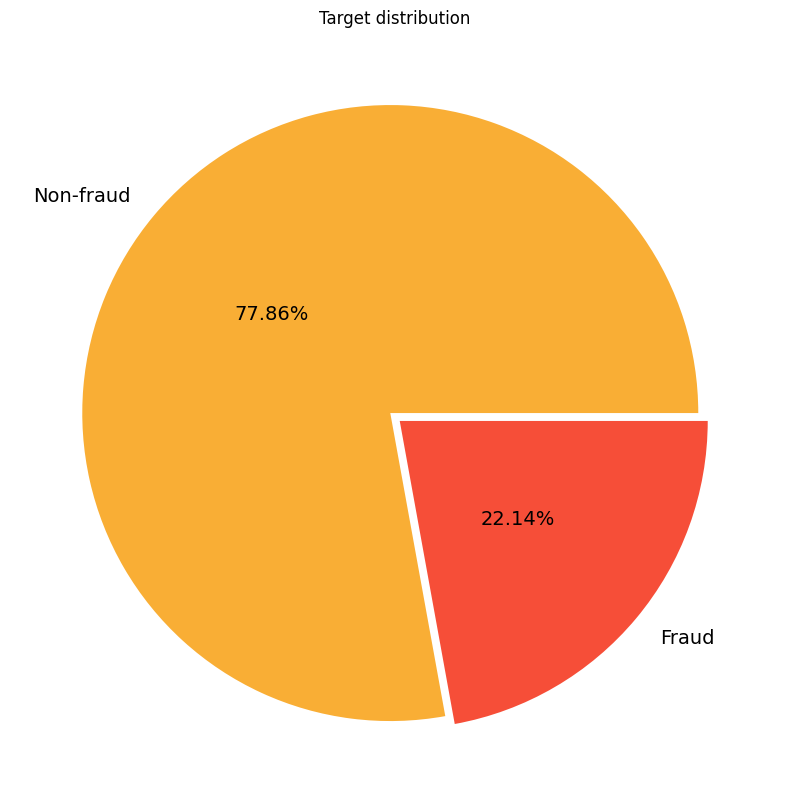

In [14]:
# Inspect target distribution
print(df['FLAG'].value_counts())

pie, ax = plt.subplots(figsize=[15,10])
labels = ['Non-fraud', 'Fraud']
colors = ['#f9ae35', '#f64e38']
plt.pie(x = df['FLAG'].value_counts(), autopct='%.2f%%', explode=[0.02]*2, labels=labels, pctdistance=0.5, textprops={'fontsize': 14}, colors = colors)
plt.title('Target distribution')
plt.show()

In [15]:
# Drop the two categorical features
string_columns = df.select_dtypes(include=['object']).columns
df = df.drop(columns=string_columns)

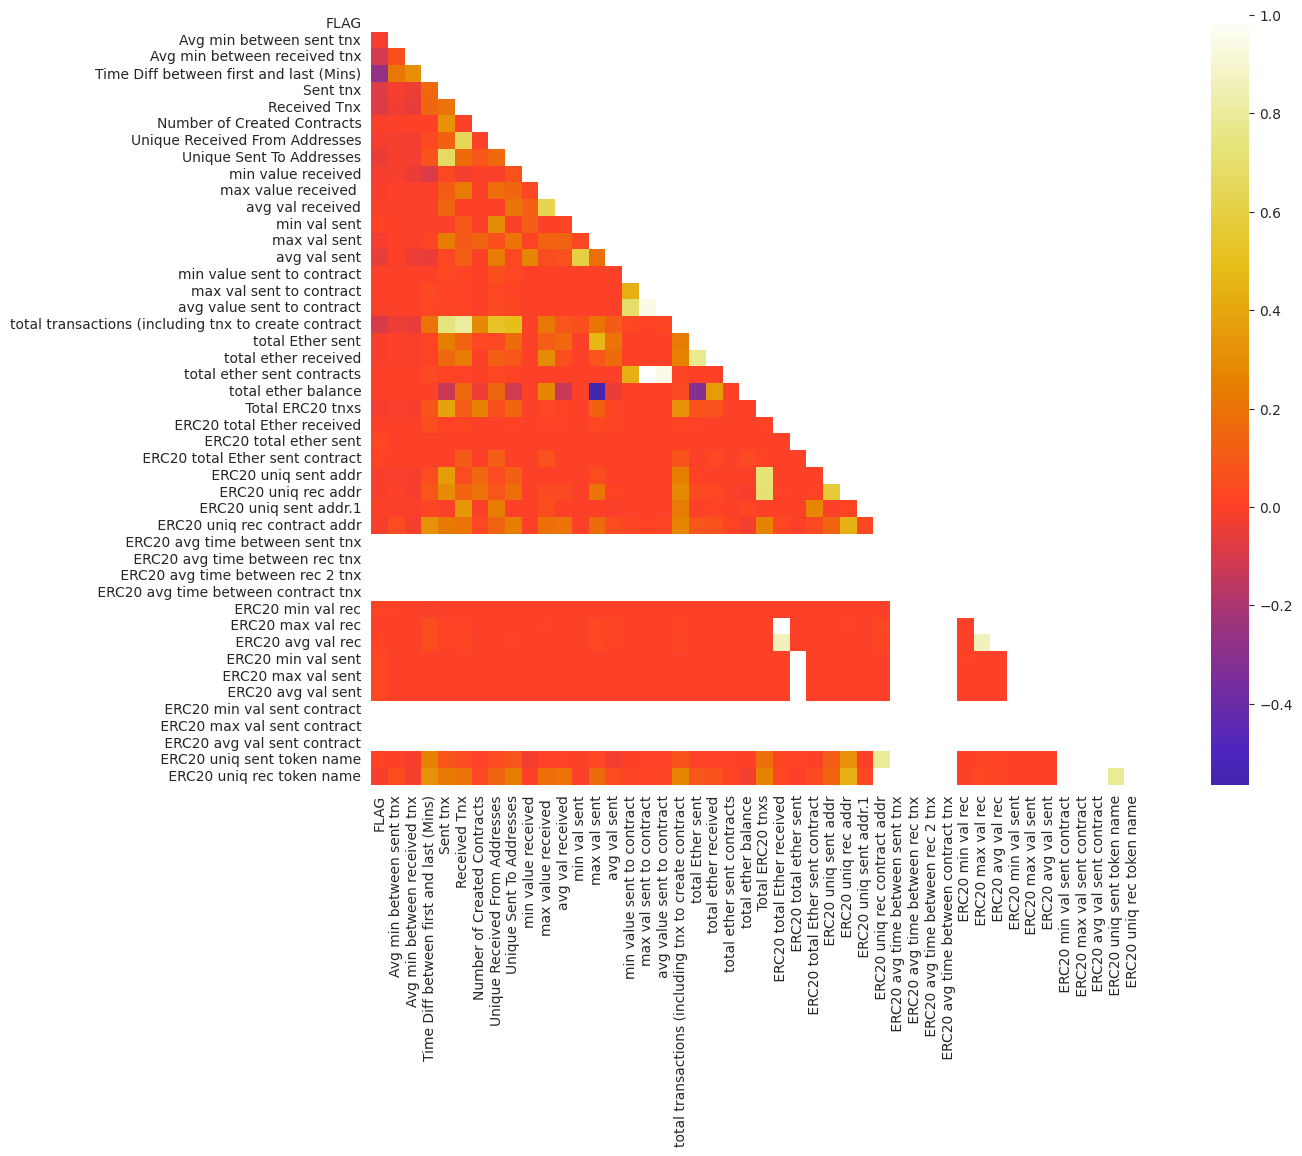

In [16]:
# Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)

###Data cleaning

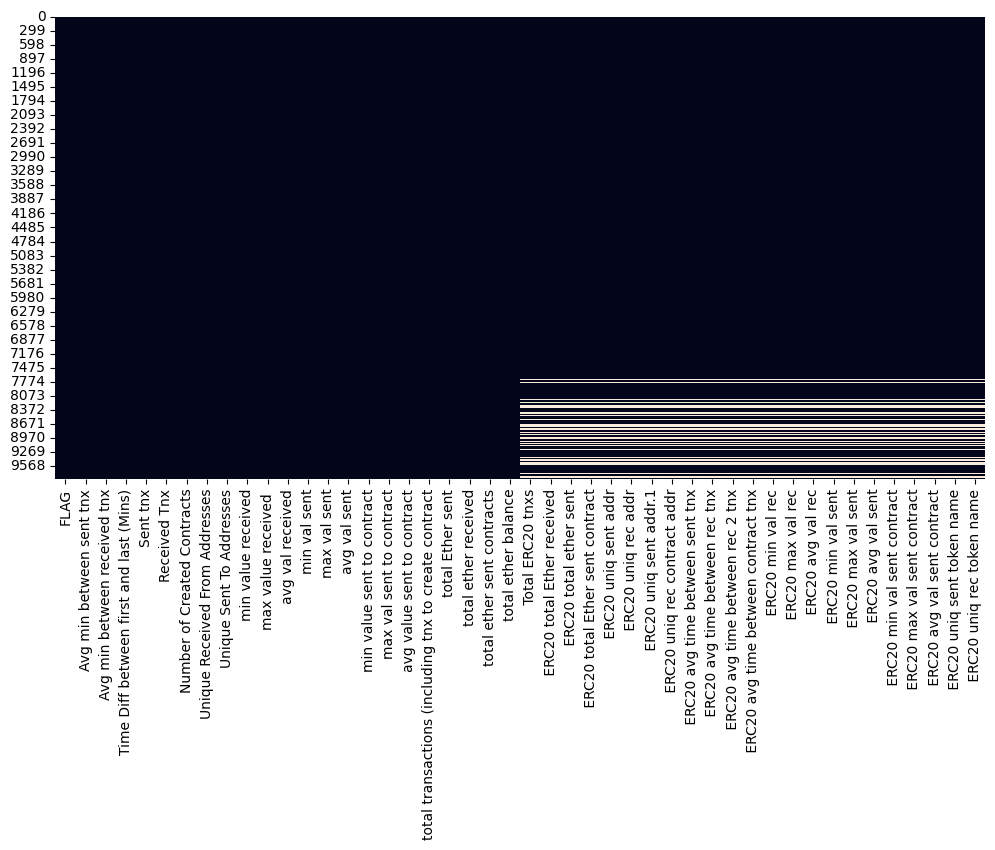

In [17]:
# Visualize missings pattern of the dataframe
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

In [18]:
# Replace missings of numerical variables with median
df.fillna(df.median(), inplace=True)

(9841, 46)


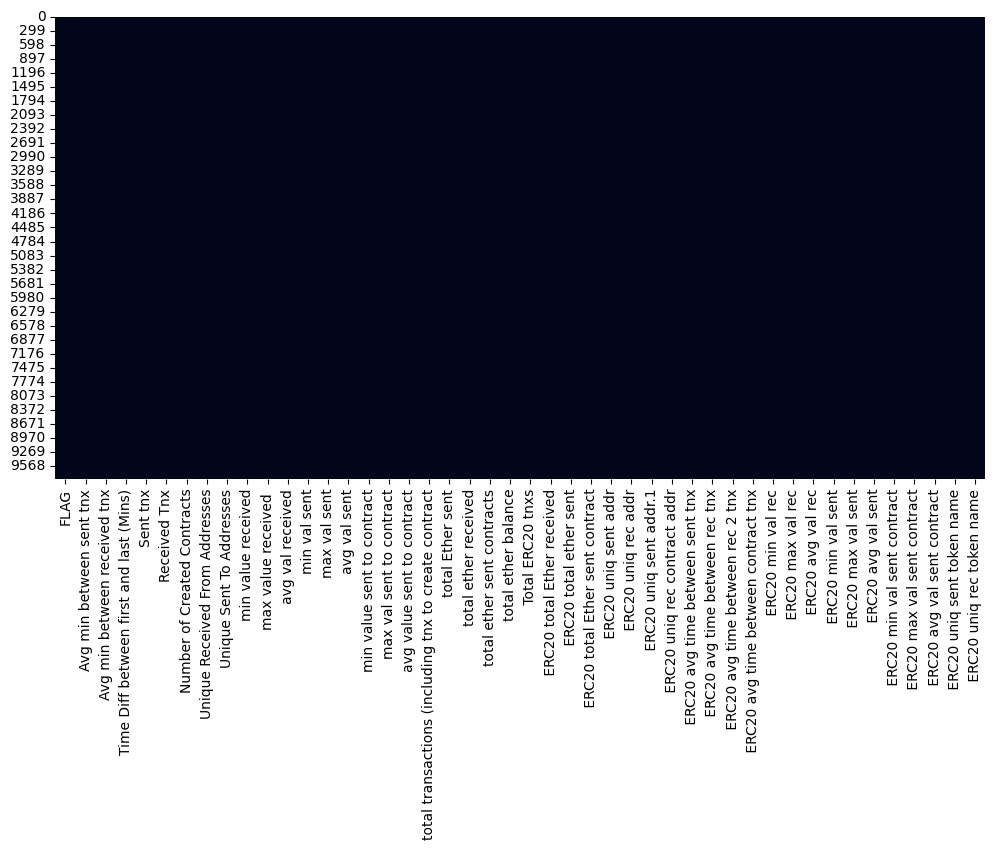

In [19]:
# Visualize missings pattern of the dataframe
print(df.shape)
plt.figure(figsize=(12,6))
sns.heatmap(df.isnull(), cbar=False)
plt.show()

####Investigating the variance of the features, it was observed that there are some features with a variance = 0

In [20]:
# Filtering the features with 0 variance
no_var = df.var() == 0
print(df.var()[no_var])
print('\n')

# Drop features with 0 variance --- these features will not help in the performance of the model
df.drop(df.var()[no_var].index, axis = 1, inplace = True)
print(df.var())
print(df.shape)

ERC20 avg time between sent tnx        0.0
ERC20 avg time between rec tnx         0.0
ERC20 avg time between rec 2 tnx       0.0
ERC20 avg time between contract tnx    0.0
ERC20 min val sent contract            0.0
ERC20 max val sent contract            0.0
ERC20 avg val sent contract            0.0
dtype: float64


FLAG                                                    1.724110e-01
Avg min between sent tnx                                4.616718e+08
Avg min between received tnx                            5.327656e+08
Time Diff between first and last (Mins)                 1.042889e+11
Sent tnx                                                5.733918e+05
Received Tnx                                            8.851734e+05
Number of Created Contracts                             2.000685e+04
Unique Received From Addresses                          8.917457e+04
Unique Sent To Addresses                                6.960121e+04
min value received                                      1.062

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9841 entries, 0 to 9840
Data columns (total 39 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   FLAG                                                  9841 non-null   int64  
 1   Avg min between sent tnx                              9841 non-null   float64
 2   Avg min between received tnx                          9841 non-null   float64
 3   Time Diff between first and last (Mins)               9841 non-null   float64
 4   Sent tnx                                              9841 non-null   int64  
 5   Received Tnx                                          9841 non-null   int64  
 6   Number of Created Contracts                           9841 non-null   int64  
 7   Unique Received From Addresses                        9841 non-null   int64  
 8   Unique Sent To Addresses                              9841 non-

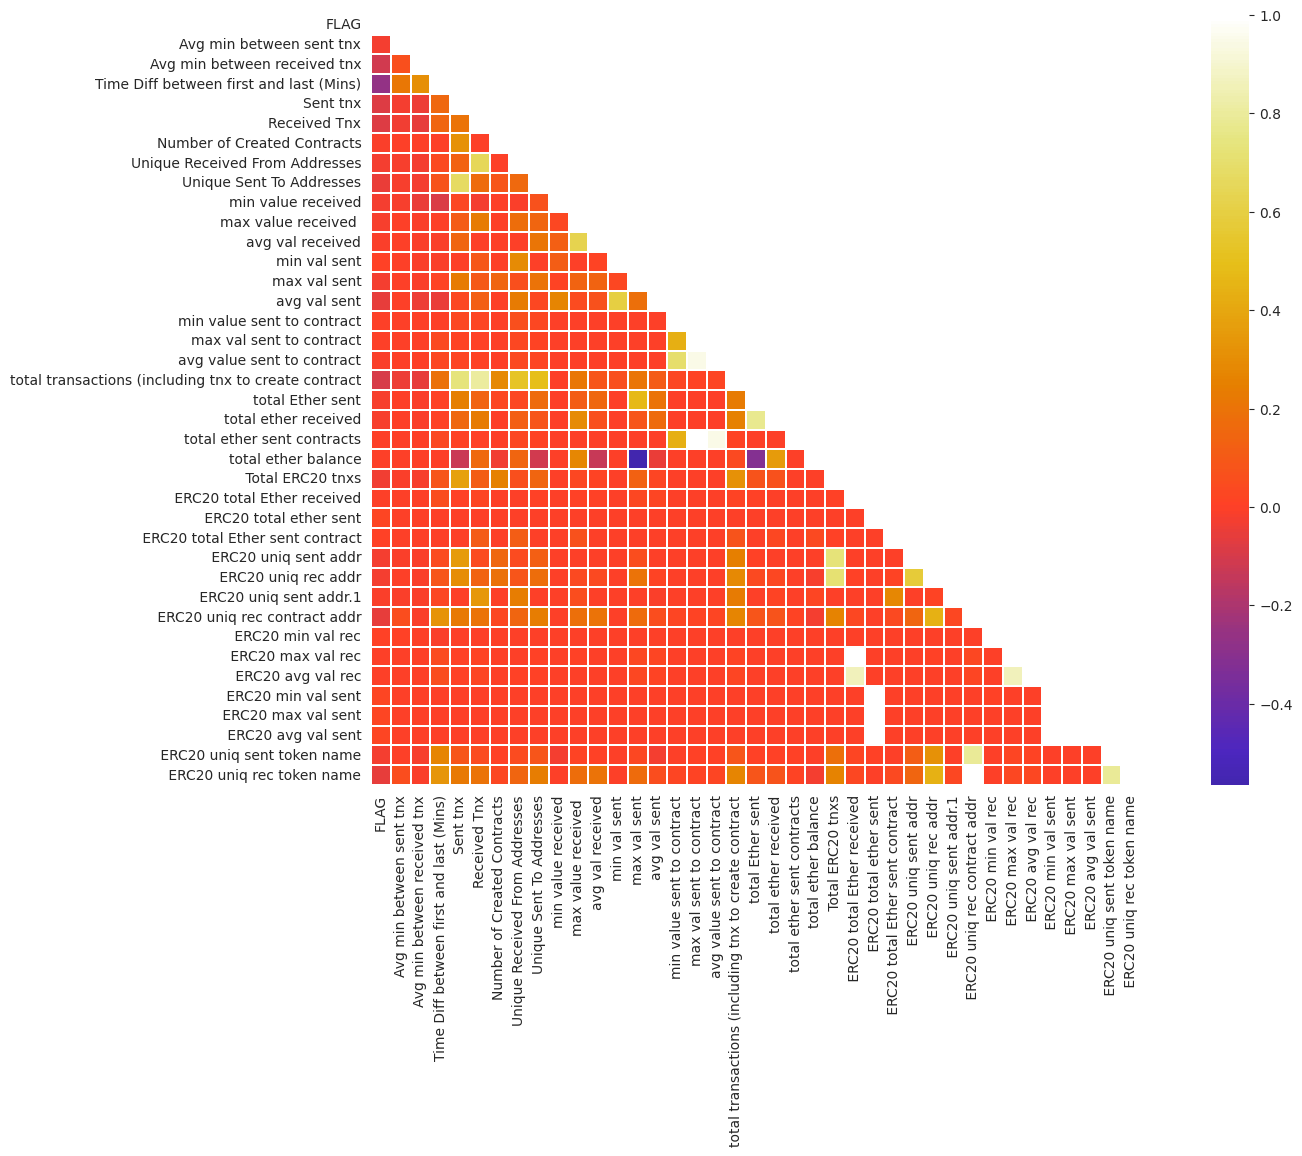

In [22]:
# Recheck the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

####Drop one of those highly correlated features
    

In [23]:
drop = ['total transactions (including tnx to create contract', 'total ether sent contracts', 'max val sent to contract', ' ERC20 avg val rec',
        ' ERC20 avg val rec',' ERC20 max val rec', ' ERC20 min val rec', ' ERC20 uniq rec contract addr', 'max val sent', ' ERC20 avg val sent',
        ' ERC20 min val sent', ' ERC20 max val sent', ' Total ERC20 tnxs', 'avg value sent to contract', 'Unique Sent To Addresses',
        'Unique Received From Addresses', 'total ether received', ' ERC20 uniq sent token name', 'min value received', 'min val sent', ' ERC20 uniq rec addr' ]
df.drop(drop, axis=1, inplace=True)

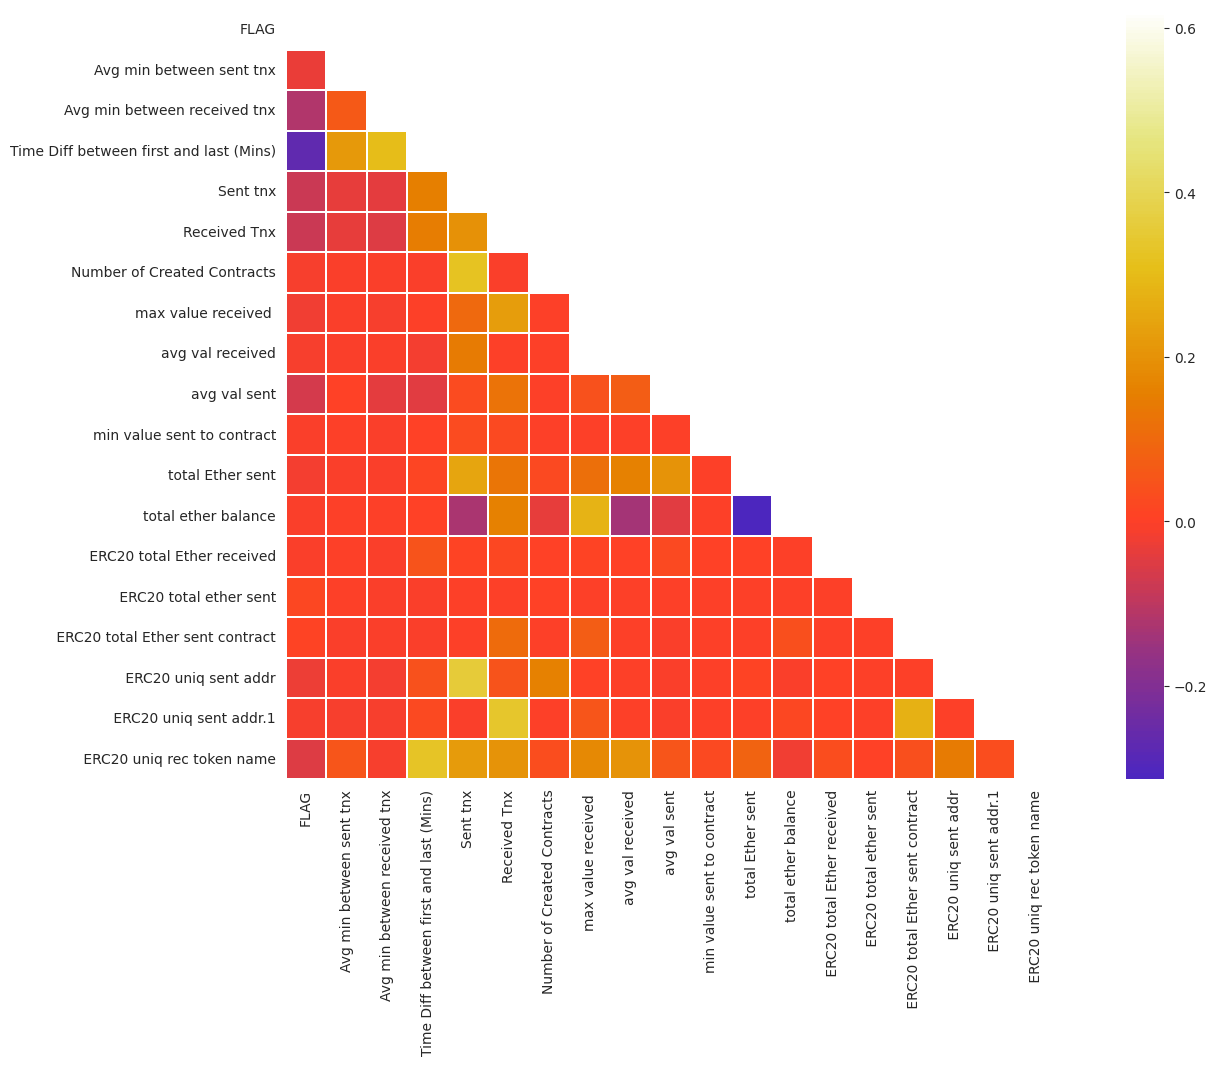

In [24]:
# Recheck the Correlation matrix
corr = df.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, linewidths=0.1, square=True)

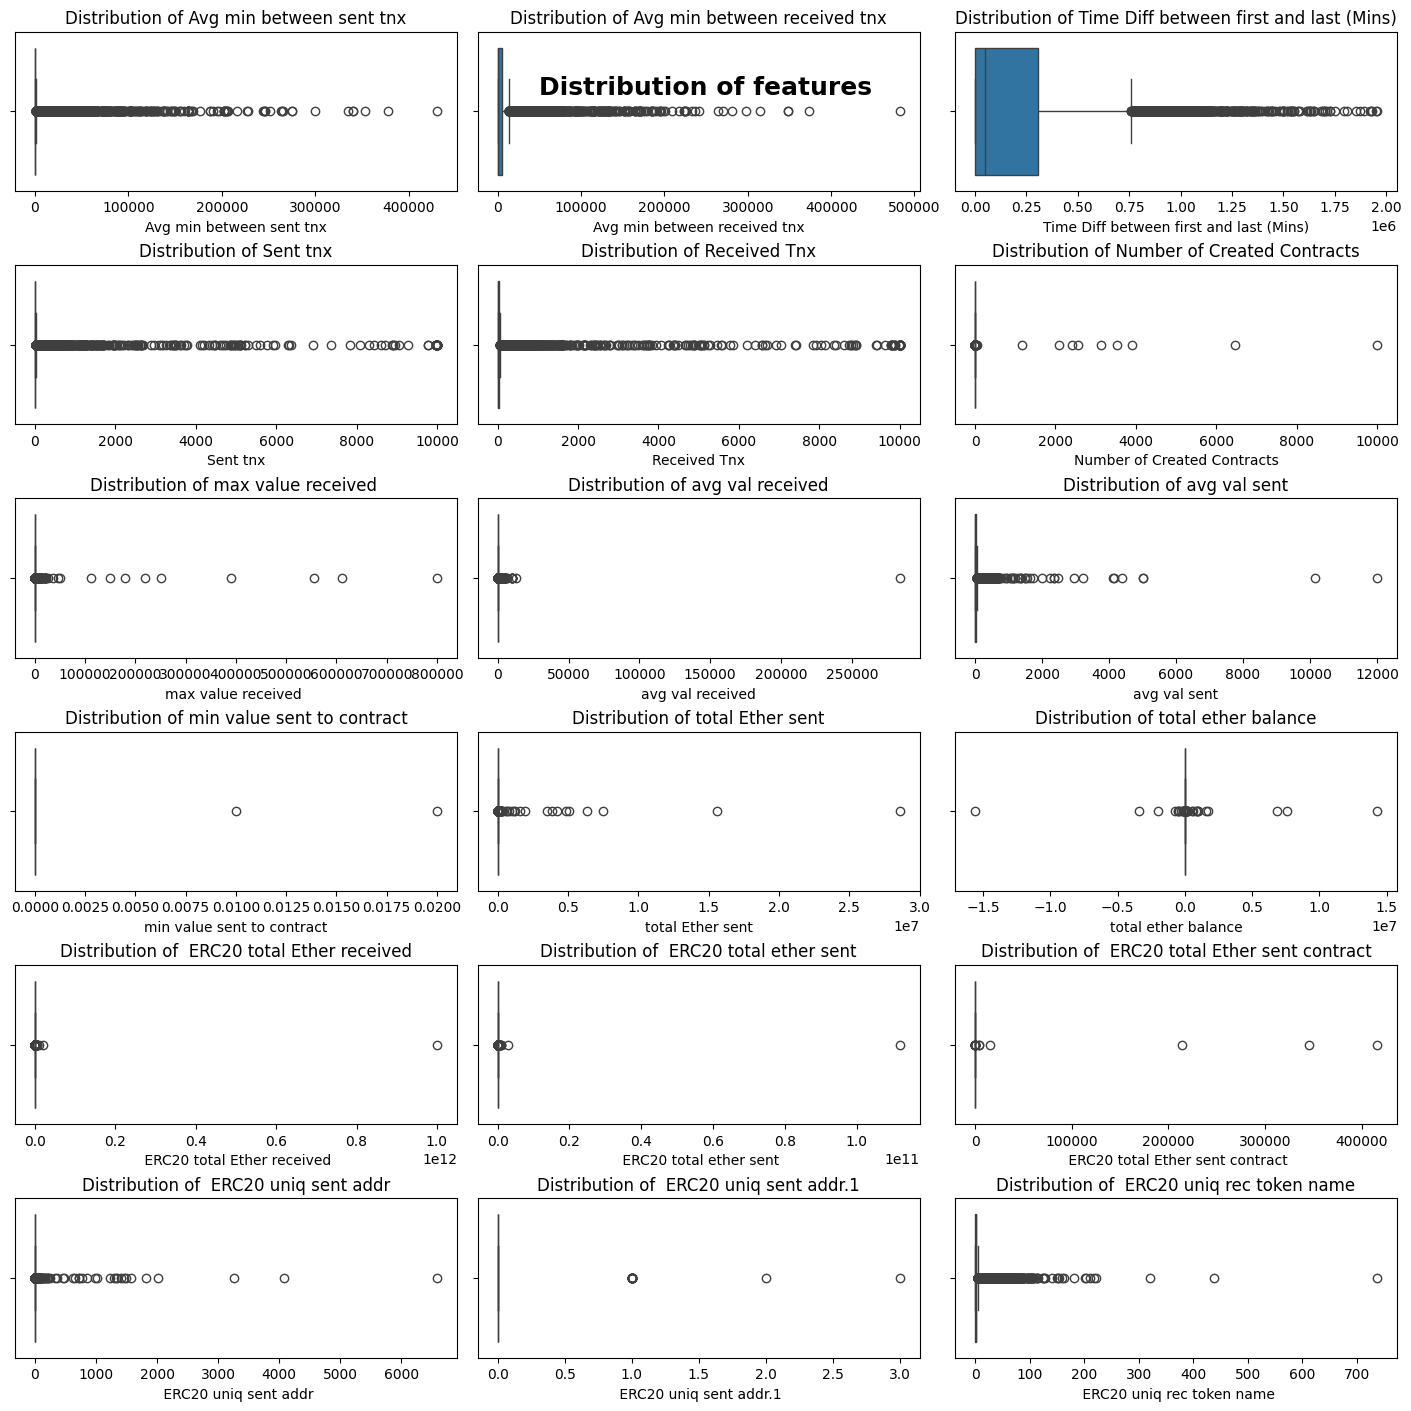

In [25]:
columns = df.columns
# Investigate the distribution of our features using boxplots
fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.7, hspace=0.8)
plt.suptitle("Distribution of features",y=0.95, size=18, weight='bold')

ax = sns.boxplot(ax = axes[0,0], data=df, x=columns[1])
ax.set_title(f'Distribution of {columns[1]}')

ax1 = sns.boxplot(ax = axes[0,1], data=df, x=columns[2])
ax1.set_title(f'Distribution of {columns[2]}')

ax2 = sns.boxplot(ax = axes[0,2], data=df, x=columns[3])
ax2.set_title(f'Distribution of {columns[3]}')

ax3 = sns.boxplot(ax = axes[1,0], data=df, x=columns[4])
ax3.set_title(f'Distribution of {columns[4]}')

ax4 = sns.boxplot(ax = axes[1,1], data=df, x=columns[5])
ax4.set_title(f'Distribution of {columns[5]}')

ax5 = sns.boxplot(ax = axes[1,2], data=df, x=columns[6])
ax5.set_title(f'Distribution of {columns[6]}')

ax6 = sns.boxplot(ax = axes[2,0], data=df, x=columns[7])
ax6.set_title(f'Distribution of {columns[7]}')

ax7 = sns.boxplot(ax = axes[2,1], data=df, x=columns[8])
ax7.set_title(f'Distribution of {columns[8]}')

ax8 = sns.boxplot(ax = axes[2,2], data=df, x=columns[9])
ax8.set_title(f'Distribution of {columns[9]}')

ax9 = sns.boxplot(ax = axes[3,0], data=df, x=columns[10])
ax9.set_title(f'Distribution of {columns[10]}')

ax10 = sns.boxplot(ax = axes[3,1], data=df, x=columns[11])
ax10.set_title(f'Distribution of {columns[11]}')

ax11 = sns.boxplot(ax = axes[3,2], data=df, x=columns[12])
ax11.set_title(f'Distribution of {columns[12]}')

ax12 = sns.boxplot(ax = axes[4,0], data=df, x=columns[13])
ax12.set_title(f'Distribution of {columns[13]}')

ax13 = sns.boxplot(ax = axes[4,1], data=df, x=columns[14])
ax13.set_title(f'Distribution of {columns[14]}')

ax14 = sns.boxplot(ax = axes[4,2], data=df, x=columns[15])
ax14.set_title(f'Distribution of {columns[15]}')

ax15 = sns.boxplot(ax = axes[5,0], data=df, x=columns[16])
ax15.set_title(f'Distribution of {columns[16]}')

ax16 = sns.boxplot(ax = axes[5,1], data=df, x=columns[17])
ax16.set_title(f'Distribution of {columns[17]}')

ax17 = sns.boxplot(ax = axes[5,2], data=df, x=columns[18])
ax17.set_title(f'Distribution of {columns[18]}')

plt.show()

In [26]:
# Some features present a small distribution
for i in df.columns[1:]:
    if len(df[i].value_counts()) < 10:
        print(f'The column {i} has the following distribution: \n{df[i].value_counts()}')
        print('======================================')

The column min value sent to contract has the following distribution: 
min value sent to contract
0.00    9839
0.02       1
0.01       1
Name: count, dtype: int64
The column  ERC20 uniq sent addr.1 has the following distribution: 
 ERC20 uniq sent addr.1
0.0    9813
1.0      26
3.0       1
2.0       1
Name: count, dtype: int64


#### It can be observed that the values of these two variables are mosty 0s. Thus, both features will be discarded since they will not be helpful for our model

In [27]:
drops = ['min value sent to contract', ' ERC20 uniq sent addr.1']
df.drop(drops, axis=1, inplace=True)
print(df.shape)
df.head()

(9841, 17)


,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,0,844.26,1093.71,704785.63,721,89,0,45.806785,6.589513,1.200681,865.691093,-279.224419,3.558854e+07,3.560317e+07,0.0,30.0,57.0
1,0,12709.07,2958.44,1218216.73,94,8,0,2.613269,0.385685,0.032844,3.087297,-0.001819,4.034283e+02,2.260809e+00,0.0,1.0,7.0
2,0,246194.54,2434.02,516729.30,2,10,0,1.165453,0.358906,1.794308,3.588616,0.000441,5.215121e+02,0.000000e+00,0.0,0.0,8.0
3,0,10219.60,15785.09,397555.90,25,9,0,500.000000,99.488840,70.001834,1750.045862,-854.646303,1.711105e+04,1.141223e+04,0.0,2.0,11.0
4,0,36.61,10707.77,382472.42,4598,20,1,12.802411,2.671095,0.022688,104.318883,-50.896986,1.628297e+05,1.235399e+05,0.0,4.0,27.0


###Data preparation

###The dataset is reduced by 75% of randomly chosen transactions to allow the program to execute correctly

In [28]:
df_reduced = df.drop(df.sample(frac=0.75).index)

In [29]:
y = df_reduced.iloc[:, 0]
X = df_reduced.iloc[:, 1:]
print(X.shape, y.shape)

(2460, 16) (2460,)


In [30]:
# Split into training (80%) and testing set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1968, 16) (1968,)
(492, 16) (492,)


In [31]:
# Normalize the training features
norm = PowerTransformer()
norm_train_f = norm.fit_transform(X_train)

In [32]:
norm_df = pd.DataFrame(norm_train_f, columns=X_train.columns)
norm_df

,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,max value received,avg val received,avg val sent,total Ether sent,total ether balance,ERC20 total Ether received,ERC20 total ether sent,ERC20 total Ether sent contract,ERC20 uniq sent addr,ERC20 uniq rec token name
0,1.477654,0.881153,1.153042,1.228801,0.865399,-0.419917,1.171268,1.156456,1.167272,1.414736,-0.010856,1.731158,-0.411857,-0.031,-0.437505,1.691122
1,-1.076757,-1.182120,-1.311331,-0.575480,-1.011481,-0.419917,-1.287843,-1.115833,-0.967653,-1.148168,-0.010934,-0.737994,-0.411857,-0.031,-0.437505,-0.995174
2,1.613550,-0.595844,0.803229,0.445942,-0.379029,-0.419917,1.307832,1.358396,1.214546,1.008653,-0.010934,1.700090,2.087869,-0.031,2.094858,1.413301
3,1.411868,0.835190,1.110840,1.392050,0.671178,-0.419917,0.001584,-0.314817,-0.675490,0.364247,-0.010926,1.792840,2.495278,-0.031,2.403553,1.871484
4,1.645514,1.565653,1.201626,0.662799,-0.379029,-0.419917,0.163208,0.433465,-0.075349,0.199515,-0.010932,1.787675,2.496232,-0.031,2.395117,1.581944
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1963,1.380738,0.531963,0.456220,0.805664,0.044387,-0.419917,-0.488088,-0.418796,-0.459624,0.007254,-0.010953,1.749583,2.498020,-0.031,2.370628,1.141746
1964,0.724556,0.035386,-0.536500,0.214583,0.437434,-0.419917,0.651298,0.355608,0.937441,0.645314,-0.010934,1.843280,-0.411857,-0.031,-0.437505,0.239875
1965,-0.162428,1.405295,0.512063,0.045171,-0.379029,-0.419917,-0.210673,-0.172471,-0.073847,-0.223477,-0.010934,-0.737994,-0.411857,-0.031,-0.437505,-0.995174
1966,-1.076757,-1.182120,-1.361000,-0.575480,-1.011481,-0.419917,-1.079062,-0.815907,-0.684716,-0.995472,-0.010934,-0.737994,-0.411857,-0.031,-0.437505,-0.995174


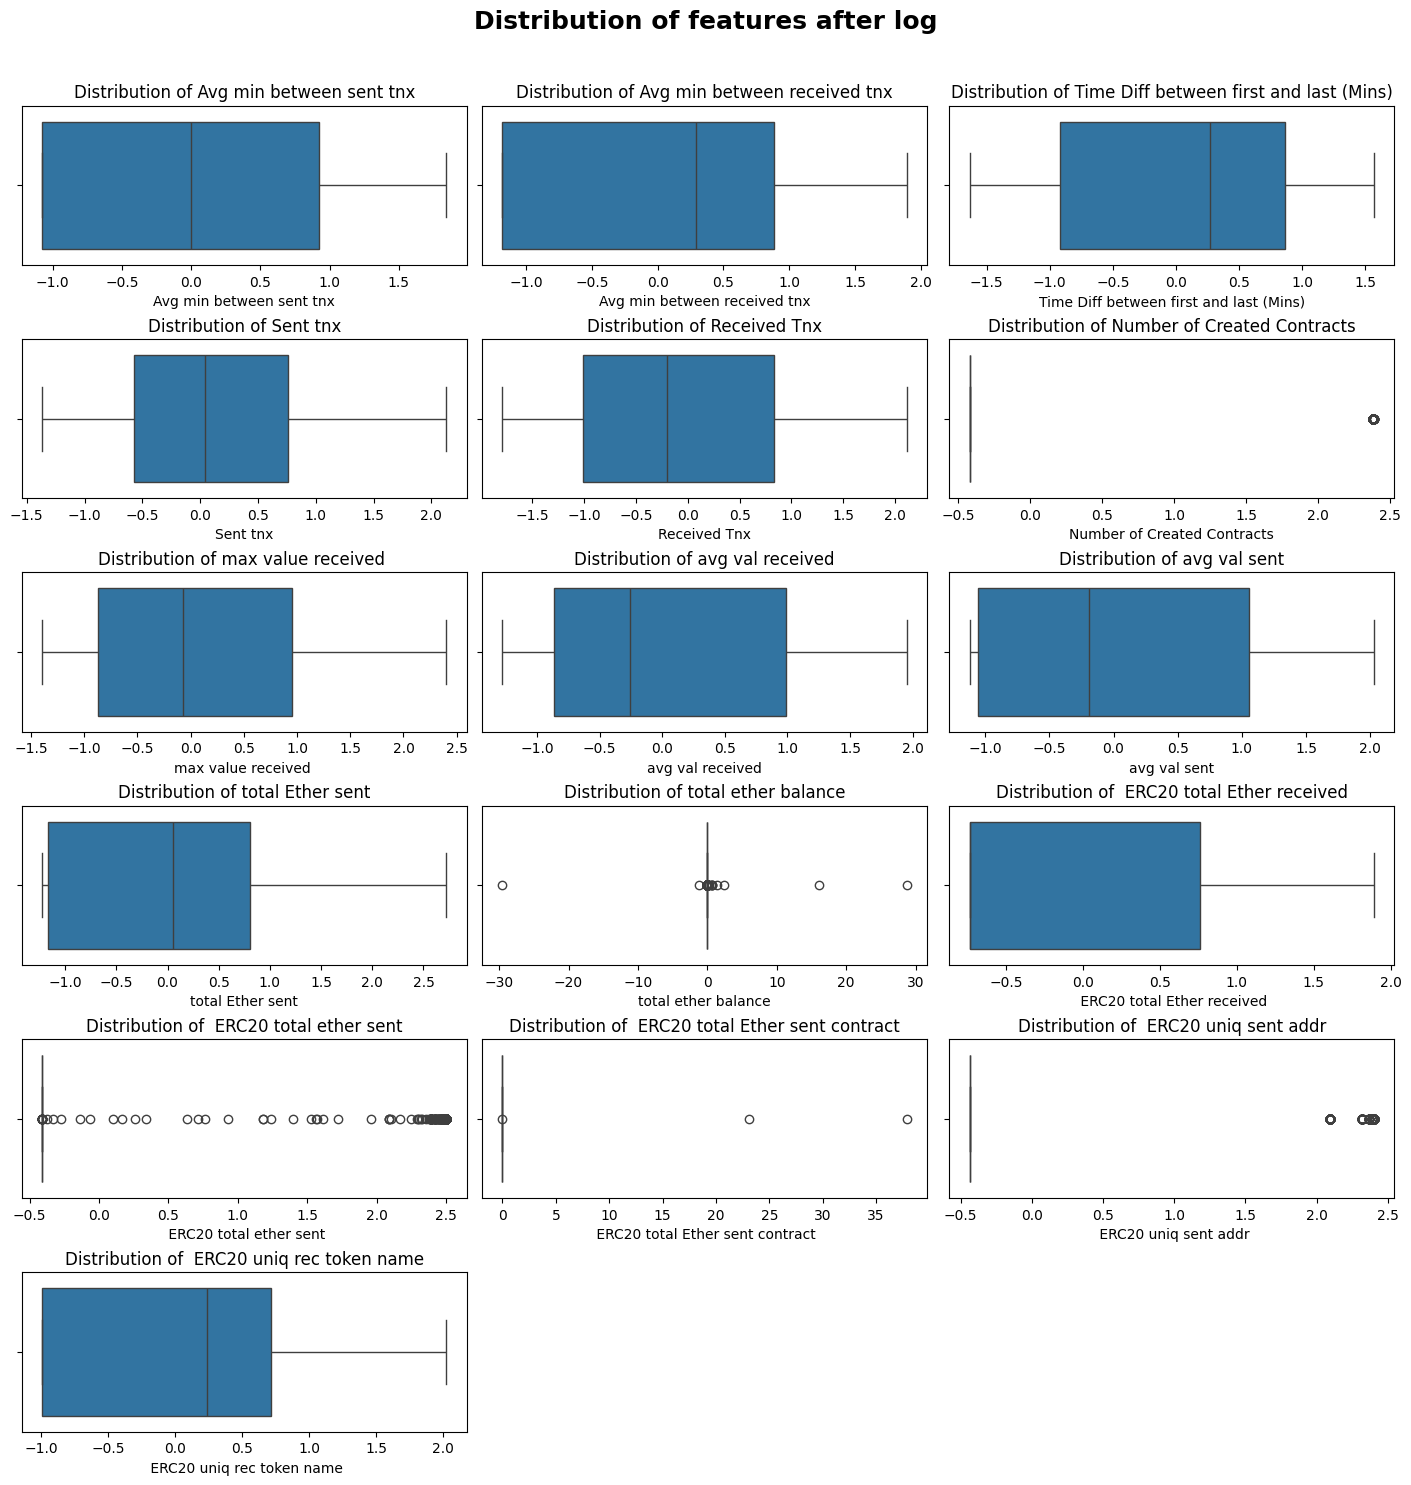

In [33]:
# Distribution of features after log transformation
fig, axes = plt.subplots(6, 3, figsize=(14, 14), constrained_layout =True)
plt.subplots_adjust(wspace = 0.7, hspace=0.8)
axes[-1, -1].axis('off') # hide axes
axes[-1, -2].axis('off') # hide axes
plt.suptitle("Distribution of features after log",y=1.05, size=18, weight='bold')

ax = sns.boxplot(ax = axes[0,0], data=norm_df, x=norm_df.columns[0])
ax.set_title(f'Distribution of {norm_df.columns[0]}')

ax1 = sns.boxplot(ax = axes[0,1], data=norm_df, x=norm_df.columns[1])
ax1.set_title(f'Distribution of {norm_df.columns[1]}')

ax2 = sns.boxplot(ax = axes[0,2], data=norm_df, x=norm_df.columns[2])
ax2.set_title(f'Distribution of {norm_df.columns[2]}')

ax3 = sns.boxplot(ax = axes[1,0], data=norm_df, x=norm_df.columns[3])
ax3.set_title(f'Distribution of {norm_df.columns[3]}')

ax4 = sns.boxplot(ax = axes[1,1], data=norm_df, x=norm_df.columns[4])
ax4.set_title(f'Distribution of {norm_df.columns[4]}')

ax5 = sns.boxplot(ax = axes[1,2], data=norm_df, x=norm_df.columns[5])
ax5.set_title(f'Distribution of {norm_df.columns[5]}')

ax6 = sns.boxplot(ax = axes[2,0], data=norm_df, x=norm_df.columns[6])
ax6.set_title(f'Distribution of {norm_df.columns[6]}')

ax7 = sns.boxplot(ax = axes[2,1], data=norm_df, x=norm_df.columns[7])
ax7.set_title(f'Distribution of {norm_df.columns[7]}')

ax8 = sns.boxplot(ax = axes[2,2], data=norm_df, x=norm_df.columns[8])
ax8.set_title(f'Distribution of {norm_df.columns[8]}')

ax9 = sns.boxplot(ax = axes[3,0], data=norm_df, x=norm_df.columns[9])
ax9.set_title(f'Distribution of {norm_df.columns[9]}')

ax10 = sns.boxplot(ax = axes[3,1], data=norm_df, x=norm_df.columns[10])
ax10.set_title(f'Distribution of {norm_df.columns[10]}')

ax11 = sns.boxplot(ax = axes[3,2], data=norm_df, x=norm_df.columns[11])
ax11.set_title(f'Distribution of {norm_df.columns[11]}')

ax12 = sns.boxplot(ax = axes[4,0], data=norm_df, x=norm_df.columns[12])
ax12.set_title(f'Distribution of {norm_df.columns[12]}')

ax13 = sns.boxplot(ax = axes[4,1], data=norm_df, x=norm_df.columns[13])
ax13.set_title(f'Distribution of {norm_df.columns[13]}')

ax14 = sns.boxplot(ax = axes[4,2], data=norm_df, x=norm_df.columns[14])
ax14.set_title(f'Distribution of {norm_df.columns[14]}')

ax15 = sns.boxplot(ax = axes[5,0], data=norm_df, x=norm_df.columns[15])
ax15.set_title(f'Distribution of {norm_df.columns[15]}')

plt.show()

###Handling the imbalance


What is Oversampling?

Oversampling is a process that involves generating new data similar to the underrepresented class.
It means creating new observations, in this case transactions, that can resemble the real ones to increase that 0.001%.
Doing oversampling is naturally very risky because in this case I am "inventing" new data that do not exist in real life, and I could risk building a Machine Learning model based on something nonexistent.
However, there's no need to worry too much because there are fairly robust techniques that allow us to use oversampling without too many qualms.

Oversampling Techniques

SMOTE

Smote (Synthetic Minority Oversampling Technique) is one of the most used techniques in this field (I have used it several times myself).

The functioning of Smote is as follows:

Find two observations of the minority class that are similar (in our case of the "fraudulent" class)
Calculate the distance between the two observations
Multiply this distance by a random value between 0 and 1
Generate a new observation that has similar characteristics to the existing ones but is entirely new
This technique can naturally only be used for quantitative variables.

> https://pulplearning.altervista.org/cose-loversampling-definizione-e-tecniche/



####Oversampling using SMOTE

In [34]:
oversample = SMOTE()
print(f'Shape of the training before SMOTE: {norm_train_f.shape, y_train.shape}')

x_tr_resample, y_tr_resample = oversample.fit_resample(norm_train_f, y_train)
print(f'Shape of the training after SMOTE: {x_tr_resample.shape, y_tr_resample.shape}')

Shape of the training before SMOTE: ((1968, 16), (1968,))
Shape of the training after SMOTE: ((3098, 16), (3098,))


In [35]:
# Target distribution before SMOTE
non_fraud = 0
fraud = 0

for i in y_test:
    if i == 0:
        non_fraud +=1
    else:
        fraud +=1

# Target distribution after SMOTE
no = 0
yes = 1

for j in y_tr_resample:
    if j == 0:
        no +=1
    else:
        yes +=1


print(f'BEFORE OVERSAMPLING \n \tNon-frauds: {non_fraud} \n \tFrauds: {fraud}')
print(f'AFTER OVERSAMPLING \n \tNon-frauds: {no} \n \tFrauds: {yes}')

BEFORE OVERSAMPLING 
 	Non-frauds: 367 
 	Frauds: 125
AFTER OVERSAMPLING 
 	Non-frauds: 1549 
 	Frauds: 1550


In [36]:
import os
dataset_dir = "./dataset"

def create_directory(directory_path):
  # Create the new directory
  if os.path.exists(directory_path) and os.path.isdir(directory_path):
      print(f'The directory "{directory_path}" already exists.')
  else:
      print(f'The folder "{directory_path}" does not exist. Creating it...')
      os.makedirs(directory_path, exist_ok=True)
      print(f'The folder "{directory_path}" created successfully!')

create_directory(dataset_dir)

The folder "./dataset" does not exist. Creating it...
The folder "./dataset" created successfully!


In [37]:
X_test.to_csv('./dataset/x_test.csv', index=False)
y_test.to_csv('./dataset/y_train.csv', index=False)
np.savetxt('./dataset/x_tr_resample.csv', x_tr_resample, delimiter=",", fmt="%d")
y_tr_resample.to_csv('./dataset/y_tr_resample.csv', index=False)

##Step 2: Download and setting up the model

[accelerate](https://huggingface.co/docs/accelerate/en/index) : Hugging face libary to run raw pytorch training script on any kind of device

[transformers](https://huggingface.co/docs/transformers): Transformers provides APIs and tools to easily download and train state-of-the-art pretrained models.

[PEFT](https://huggingface.co/docs/peft/en/index) : (Parameter-Efficient Fine-Tuning) is a library for efficiently adapting large pretrained models to various downstream applications without fine-tuning all of a model’s parameters because it is prohibitively costly.  

[Bitsandbytes](https://huggingface.co/docs/bitsandbytes/main/en/index) : library is a lightweight Python wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication (LLM.int8()), and 8 & 4-bit quantization functions.

[TRL](https://github.com/huggingface/trl) : library is a full stack tool to fine-tune and align transformer language and diffusion models using methods such as Supervised Fine-tuning step (SFT), Reward Modeling (RM) and the Proximal Policy Optimization (PPO) as well as Direct Preference Optimization (DPO).


###Install and import Libraries

In [38]:
%pip install -q accelerate==0.30.1 transformers==4.38.2 peft==0.4.0 bitsandbytes==0.41.3 trl==0.4.7 os-win==5.9.0 datasets==2.19.1 safetensors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 97.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.4/77.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.4/274.4 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 361.6/361.6 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.0/172.0 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 4.4 MB/s eta 0:00:00
 

In [39]:
import os
import torch
from transformers import (
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline,
    logging,
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from datasets import Dataset
from peft import LoraConfig, PeftModel
from trl import SFTTrainer

from torch.utils.tensorboard import SummaryWriter

In [40]:
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [41]:
# The model that you want to train from the Hugging Face hub
model_name = 'microsoft/phi-2'

# Fine-tuned model name
new_model = "phi2-etherum_fraud_detection"

### QLoRA parameters

In [42]:
# QLoRA parameters

# LoRA attention dimension
lora_r = 64

# Alpha parameter for LoRA scaling
lora_alpha = 16

# Dropout probability for LoRA layers
lora_dropout = 0.1

### Bitsandbytes parameters

In [43]:
# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

### TrainingArguments parameters


In [44]:
# Create a new directory named results to contain output
# Output directory where the model predictions and checkpoints will be stored
results_dir = "./results"

create_directory(results_dir)

# Number of training epochs
num_train_epochs = 10

# Enable fp16/bf16 training (set bf16 to True with an A100)
fp16 = False
bf16 = False

# Batch size per GPU for training
per_device_train_batch_size = 4

# Batch size per GPU for evaluation
per_device_eval_batch_size = 4

# Number of update steps to accumulate the gradients for
gradient_accumulation_steps = 1

# Enable gradient checkpointing
gradient_checkpointing = True

# Maximum gradient normal (gradient clipping)
max_grad_norm = 0.3

# Initial learning rate (AdamW optimizer)
learning_rate = 2e-4

# Weight decay to apply to all layers except bias/LayerNorm weights
weight_decay = 0.001

# Optimizer to use
optim = "paged_adamw_32bit"

# Learning rate schedule
lr_scheduler_type = "cosine"

# Number of training steps (overrides num_train_epochs)
max_steps = -1

# Ratio of steps for a linear warmup (from 0 to learning rate)
warmup_ratio = 0.03

# Group sequences into batches with same length
# Saves memory and speeds up training considerably
group_by_length = True

# Save checkpoint every X updates steps
save_steps = 0

# Log every X updates steps
logging_steps = 25

The folder "./results" does not exist. Creating it...
The folder "./results" created successfully!


### SFT parameters

In [45]:
# Maximum sequence length to use
max_seq_length = None

# Pack multiple short examples in the same input sequence to increase efficiency
packing = False

# Load the entire model on the GPU 0
device_map = {"": 0}

In [46]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

Your GPU supports bfloat16: accelerate training with bf16=True


### Load base model

In [47]:
model = AutoModelForCausalLM.from_pretrained(
model_name,
quantization_config=bnb_config,
device_map=device_map
)

model.config.use_cache = False
model.config.pretraining_tp = 1

# Load LLaMA tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

# Load LoRA configuration
peft_config = LoraConfig(
lora_alpha=lora_alpha,
lora_dropout=lora_dropout,
r=lora_r,
bias="none",
task_type="CAUSAL_LM",
target_modules= ["Wqkv", "fc1", "fc2" ] # ["Wqkv", "out_proj", "fc1", "fc2" ] #["Wqkv", "out_proj"]
)

config.json:   0%|          | 0.00/735 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.7k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/564M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/7.34k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [48]:
# Set training parameters
training_arguments = TrainingArguments(
    output_dir=results_dir,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=per_device_train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    optim=optim,
    save_steps=save_steps,
    logging_steps=logging_steps,
    learning_rate=learning_rate,
    weight_decay=weight_decay,
    fp16=fp16,
    bf16=bf16,
    max_grad_norm=max_grad_norm,
    max_steps=max_steps,
    warmup_ratio=warmup_ratio,
    group_by_length=group_by_length,
    lr_scheduler_type=lr_scheduler_type,
    report_to="tensorboard"
)

#Step 3: Training and evaluation of the model

###Adattamento per SFTTrainer

In [49]:
# Function to convert numeric data to strings
def convert_to_text(dataset):
    texts = []
    for i in range(len(dataset)):
        row = dataset[i]
        text = ' '.join(str(row[col]) for col in dataset.column_names if col != 'FLAG')
        texts.append(text)
    dataset = dataset.add_column("text", texts)
    return dataset

In [50]:
#Concatenation of two datasets after oversample
df_x = pd.DataFrame(x_tr_resample, columns=X.columns)
df_y = pd.DataFrame(y_tr_resample, columns=['FLAG'])

train = pd.concat([df_y, df_x], axis=1)

# Convert the DataFrame to a Python dictionary
data_dict = train.to_dict(orient='list')

# Create a Hugging Face dataset
new_train = Dataset.from_dict(data_dict)

# Save the dataset to a file
new_train.save_to_disk('./results/dataset/train')

Saving the dataset (0/1 shards):   0%|          | 0/3098 [00:00<?, ? examples/s]

In [51]:
#Concatenation of two datasets
df_x_test = pd.DataFrame(X_test, columns=X.columns)
df_y_test = pd.DataFrame(y_test, columns=['FLAG'])

test = pd.concat([df_y_test, df_x_test], axis=1)

# Convert the DataFrame to a Python dictionary
data_dict = test.to_dict(orient='list')

# Create a Hugging Face dataset
new_test = Dataset.from_dict(data_dict)

# Save the dataset to a file
new_test.save_to_disk('./results/dataset/test')

Saving the dataset (0/1 shards):   0%|          | 0/492 [00:00<?, ? examples/s]

In [52]:
# Convert the datasets
new_train = convert_to_text(new_train)
new_test = convert_to_text(new_test)

###Tranining

####Compute metrics Function

In [53]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Check the shape of the labels
    print("Shape delle etichette (labels):", labels.shape)

    num_outputs = labels.shape[1]  # Number of target variables
    print(f"Numero di variabili target: {num_outputs}")

    # Merge all outputs into one list
    all_y_true = labels.flatten()
    all_y_pred = preds.flatten()

    # Print the combined indexes
    print("Indici combinati:")
    print(f"all_y_true: {all_y_true}")
    print(f"all_y_pred: {all_y_pred}")

    # Calculate generic metrics
    precision, recall, f1, _ = precision_recall_fscore_support(all_y_true, all_y_pred, average='macro')
    acc = accuracy_score(all_y_true, all_y_pred)
    conf_matrix = confusion_matrix(all_y_true, all_y_pred)

    metrics = {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'confusion_matrix': conf_matrix
    }

    return metrics

def plot_confusion_matrix(conf_matrix, labels, title):
    fig, ax = plt.subplots()
    im = ax.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(conf_matrix.shape[1]),
           yticks=np.arange(conf_matrix.shape[0]),
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = 'd'
    thresh = conf_matrix.max() / 2.
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(j, i, format(conf_matrix[i, j], fmt),
                    ha="center", va="center",
                    color="white" if conf_matrix[i, j] > thresh else "black")
    fig.tight_layout()
    plt.show()

####Set the SFT Trainer

In [64]:
# Set Supervised Fine-Tuning parameters
trainer = SFTTrainer(
    model=model,
    train_dataset=new_train,
    eval_dataset=new_test,
    peft_config=peft_config,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    tokenizer=tokenizer,
    args=training_arguments,
    packing=packing,
    compute_metrics=compute_metrics
)

# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained(new_model)
# Save associate tokenizer
tokenizer.save_pretrained(new_model)

NameError: name 'model' is not defined

In [ ]:
from safetensors.torch import save_file
model_weights = trainer.model.state_dict()

# Salva i pesi in formato .safetensors
save_file(model_weights, "model.safetensors")

In [ ]:
import shutil

# Definisci la cartella da comprimere e il nome del file zip
folder_to_zip = './phi2-etherum_fraud_detection'  # La cartella che vuoi comprimere
output_zip = './phi2-etherum_fraud_detection'  # Nome del file zip senza estensione

# Crea il file zip
shutil.make_archive(output_zip, 'zip', folder_to_zip)

print(f"Cartella '{folder_to_zip}' compressa in '{output_zip}.zip'.")

In [ ]:
# Definisci la cartella da comprimere e il nome del file zip
folder_to_zip = './dataset'  # La cartella che vuoi comprimere
output_zip = './dataset'  # Nome del file zip senza estensione

# Crea il file zip
shutil.make_archive(output_zip, 'zip', folder_to_zip)

print(f"Cartella '{folder_to_zip}' compressa in '{output_zip}.zip'.")

In [ ]:
# Definisci la cartella da comprimere e il nome del file zip
folder_to_zip = './results'  # La cartella che vuoi comprimere
output_zip = './results'  # Nome del file zip senza estensione

# Crea il file zip
shutil.make_archive(output_zip, 'zip', folder_to_zip)

print(f"Cartella '{folder_to_zip}' compressa in '{output_zip}.zip'.")

In [67]:
from google.colab import files
files.download('results.zip')
files.download('dataset.zip')
files.download('phi2-etherum_fraud_detection.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##Resutls

In [ ]:
 %load_ext tensorboard
 %tensorboard --logdir results/runs

In [ ]:
del X
del y
del x_tr_resample
del y_tr_resample
del X_test
del y_test
del ax
del ax1
del ax2
del ax3
del ax4
del ax5
del ax6
del ax7
del ax8
del ax9
del ax10
del ax11
del ax12
del ax13
del ax14
del ax15
del ax16
del ax17
del df
del df_x
del df_y
del df_x_test
del df_y_test
del train
del test
del corr
del data_dict
del dataset_dir
del y_train
del X_train
del axes
del bf16
del bnb_4bit_compute_dtype
del bnb_4bit_quant_type
del compute_dtype
del drop
del drops
del fig
del folder_to_zip
del fp16
del mask
del norm_df
del norm_train_f
del bnb_config
del categories
del columns
del no_var
del numericals
del colors
del device_map
del fraud
del gradient_accumulation_steps
del gradient_checkpointing
del group_by_length
del lora_alpha
del lora_dropout
del lora_r
del labels
del learning_rate
del lr_scheduler_type
del max_grad_norm
del max_seq_length
del max_steps
del model
del model_name
del num_train_epochs
del no
del non_fraud
del i
del j
del logging_steps
del major
del norm
del optim
del output_zip
del oversample
del pie
del per_device_eval_batch_size
del per_device_train_batch_size
del save_steps
del use_4bit
del use_nested_quant
del warmup_ratio
del weight_decay
del yes
del results_dir
del string_columns
del packing
del df_reduced

In [ ]:
import gc
gc.collect()

In [65]:
torch.cuda.empty_cache()
results = trainer.evaluate()
print(results)

Trainer is attempting to log a value of "[[   0 4712    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 ...
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]
 [   0    0    0 ...    0    0    0]]" of type <class 'numpy.ndarray'> for key "eval/confusion_matrix" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


Shape delle etichette (labels): (492, 70)
Numero di variabili target: 70
Indici combinati:
all_y_true: [19707    13  2920 ...  -100  -100  -100]
all_y_pred: [  13   16 2791 ...    0    0    0]
{'eval_loss': 5.56035041809082, 'eval_accuracy': 0.001480836236933798, 'eval_f1': 0.0004106963517604801, 'eval_precision': 0.0007722569113188917, 'eval_recall': 0.0006228456205473118, 'eval_confusion_matrix': array([[   0, 4712,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       ...,
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0],
       [   0,    0,    0, ...,    0,    0,    0]]), 'eval_runtime': 40.9188, 'eval_samples_per_second': 12.024, 'eval_steps_per_second': 1.515, 'epoch': 10.0}
